# Simulació llit elàstic

Aquest codi es basa en discretitzar un llit elàstic similar al del fisidabo, que és una xarxa quadrada, i aplicar en ell les equacions del moviment. Cada punt de la xarxa quadrada se li associa una petita massa 'dm'. I la corda es considera com una sèrie de molles molt rígides, amb una distància de repòs 'dist_repos', i una constant de rigidesa 'K'. Molles entre els punts d'unió de la xarxa que estan units per corda.

Per a aclariments mirar una de les llibretes que regalaven de la UPC i que té altres coses variades de mates.

In [2]:
Elasticitat_cordill = 175
Tensio_inicial = 1.4
Elasticitat_molla_metall = 400 #Paràmetre que en un principi no cal modificar

### El control de la sortida en un .txt es controla al final del programa

In [3]:
%matplotlib notebook

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as t

#PROPIETATS DEL TEIXIT/CORIDLL
x_nodes = 214 #Nombre de creuaments entre cordes quan ens movem en l'eix x, que és el llarg
y_nodes = 150 #Nombre de creuaments entre cordes quan ens movem en l'eix y, que és el curt

#Mida del llit elàstic sense gravetat (sense deformacio, tal i com ho fa en començar la simulació), en cada dimensió.
#En metres. Només de la part que és corda, no les molles que subjecten
x_mida_inici = 3.6 
y_mida_inici = 1.8

#Considerem de moment una elasticitat i una massa uniforme:
densitat = 0.01 #En Kg per metre de corda
K = Elasticitat_cordill #Mòdul d'elasticitat de la corda, multiplicat per la secció. En Newtons (per metre estirat i en un metre de corda).


#PROPIETATS DE LES MOLLES DE METALL
K_molla = Elasticitat_molla_metall #Elasticitat de les molles de metall al voltant del llit (són les que permeten més deformació i lliguen el llit 
# a les barres de suport laterals)
L_molla = 0.40 #Longitud molles de metall
#Podríem afegir també la densitat de les molles


#SITUACIO INICIAL
Tensio_inicial = Tensio_inicial #En Newtons, força que hi ha sobre el llit elàstic en ambdós eixos en començar el llit horizontal.

#Penjem una anella de massa de les següents característiques:
massa_esfera = 67.5 #En kg, massa penjada
Radi = 0.1
Radi_intern = 0.05

#Domini temporal
#timestep = 0.0005
#temps_simulació = 1 #En segons
g = 9.8 #Vity

In [5]:
#REINICIAT DEL LLIT
#A continuació elegim les posicions inicials dels creuaments i dels punts importants (fixació als voltants/contorns), 
#i ho posem en la matriu Pos
x_indexs = x_nodes+4
y_indexs = y_nodes+4
Pos = np.zeros((x_indexs, y_indexs, 3))   #Les posicions de cada un dels creuaments en l'espai de 3 dimensions, 
#començant per 2 i acabant per x_nodes+1 o y_nodes+1 depenent de la direcció. En la posició 0 i en la posició final x_nodes+3 
#o y_nodes+3 correspon als punts de l'espai que són fixes per a aquest llit elàstic, els que s'enganxen a les barres 
#metàl·liques laterals en el nostre cas

#Nombre de masses que tindran dinàmica en cada cordill segons l'eix
x_masses = x_nodes+2
y_masses = y_nodes+2
Gird = np.mgrid[0:x_mida_inici:(x_masses)*1j,0:y_mida_inici:(y_masses)*1j]  #crea una graella, com les que serveixen 
#per a fer gràfics de superfícies, amb la part complexa de divisions i la part real d'interval a dividir.
#Aquesta Gird seria la part de teixit del llit elàstic

Pos[1:-1,1:-1,0] = Gird[0]  #Assignem les posicions en l'eix X de la part de texit
Pos[1:-1,1:-1,1] = Gird[1]  #Assignem les posicions en l'eix Y de la part de texit
#En l'eix Z la posició comença amb un 0

#Falta afegir la longitud de les molles de metall.
Pos[1:-1,1:-1,0:2] = Pos[1:-1,1:-1,0:2] + L_molla

#I omplir els espais de les posicions fixes de contorn que havíem deixat buits
Pos[0,:,1] = Pos[1,:,1]
Pos[-1,:,1] = Pos[1,:,1]
Pos[:,-1,1] = Pos[:,-2,1] + L_molla
Pos[:,0,0] = Pos[:,1,0]
Pos[:,-1,0] = Pos[:,1,0]
Pos[-1,:,0] = Pos[-2,:,0] + L_molla

#Mides en "repòs" (sense gravetat), hi pot haver tensió en repòs no nul·la
longitud_inici_x = Pos[2,1,0] - Pos[1,1,0]
longitud_inici_y = Pos[1,2,1] - Pos[1,1,1]

#CINEMÀTICA INICIAL
Vel = np.zeros((x_masses,y_masses,3)) #Velocitat inicialitzada a 0

altura_centre = np.array([]) #Inicialitzem un vector que guardarà l'altura del centre de llit elàstic

<IPython.core.display.Javascript object>


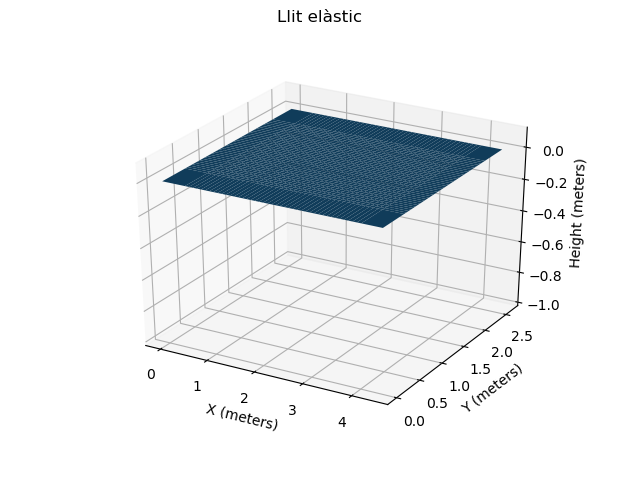

In [7]:
# Plot the surface.
#PLOT A SURFACE
fig = plt.figure('Llit')
ax = fig.gca(projection='3d')

fig.suptitle("Llit elàstic")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
ax.set_zlabel('Height (meters)')
ax.set_zlim(-1,0.1)

surf = ax.plot_surface(Pos[:,:,0], Pos[:,:,1], Pos[:,:,2], antialiased=True)
#plt.savefig("Llit estàtic Buit K20, 3D")

In [48]:
#PREPARACIÓ DE LES FORCES DE TENSIÓ

#Equació que ens dóna la tensió T = (K/x_eq)(long_rep - x_eq) = K(long_rep/x_eq - 1)
# T/K +1 = Long_rep/x_eq --> x_eq = long_rep/(T/K +1)
x_dist_repos = longitud_inici_x/(Tensio_inicial/K + 1)
y_dist_repos = longitud_inici_y/(Tensio_inicial/K + 1)
molla_dist_repos = L_molla/(Tensio_inicial/K_molla + 1)

k_x = K/x_dist_repos #Constant d'elasticitat de les molles en l'eix x
k_y = K/y_dist_repos #Constant d'elasticitat de les molles en l'eix y
k_molla = K/molla_dist_repos #Constant d'elasticitat de les molles de metall

deformacio_inicial_x = longitud_inici_x - x_dist_repos
deformacio_inicial_y = longitud_inici_y - y_dist_repos
deformacio_inicial_molla = L_molla - molla_dist_repos

In [7]:
#DINÀMICA
#Matriu de masses
dm = densitat*(x_dist_repos + y_dist_repos) #Perquè hi ha quatre mitjos de massa de corda per cada creuament, i perquè 
#considerem que en repòs, les densitats de les cordes en ambdues direccions són iguals i valen 'densitat'
#Considerem ara la matriu de les masses de cada punt
Masses = dm * np.ones((x_masses, y_masses)) #Les caselles (i,j) es refereixen a la massa del node en la posició (i+1,j+1).
#Allí on s'enganxen les molles no es considera exactament un node (almenys no un node com a creuament de teixit).
#L'índex comença a partir de 0 i va fins x_nodes+1 o fins y_nodes+1.

#-------------------------------------------------------------------#
# Afegirem una massa uniforme en forma de circumferència de 67,5 kg #
#-------------------------------------------------------------------#
index_centre = (int(x_masses/2), int(y_masses/2)) #Aquest índex fa referència només allí on ocorre dinàmica
index_pos_centre = (index_centre[0]+1, index_centre[1]+1) 

#Primer contem el nombre de creuaments en una circumferència de radi Radi centrada en index_centre
def distancia_centre(index):
    "Retorna la distància euclídia de l'encreuament a la que fa referència l'índex respecte l'encreuament central del llit"
    metrica = np.array([longitud_inici_x, longitud_inici_y]) #Distancia que avancem per cada moviment de l'índex
    index_relatiu = index - np.array (index_centre)
    posicio_relativa = index_relatiu*metrica
    return np.linalg.norm(posicio_relativa)


Anella = np.zeros((x_masses, y_masses))
for x in range(x_masses):
    for y in range(y_masses):
        index = np.array([x,y])
        if (Radi_intern < distancia_centre(index) < Radi):
            #print('dins l'anella')
            Anella[x,y] = 1
            
caselles_afectades = sum(sum(Anella))
densitat_uniforme_bola = massa_esfera/caselles_afectades
Massa_bola = Anella * densitat_uniforme_bola
Masses = Masses + Massa_bola

In [8]:
#A saco de data
print("Pos centre:", index_pos_centre)
print ("Massa d'un encreuament =", dm)
print ('Massa del cordill =', sum(sum(Masses)) - massa_esfera) #Massa del llit elàstic
estimació_mida_errors = 2e-16*4*K*(x_nodes+1)/(x_mida_inici*dm)
print('Estimació_error_numèric_per_iteració:', estimació_mida_errors)
mida_inicial_x = longitud_inici_x
mida_inicial_y = longitud_inici_y
print('Mida inicial de les molles, eixx', mida_inicial_x)
print('Mida inicial de les molles, eixy', mida_inicial_y)
print('Allargament inicial eix X', deformacio_inicial_x)
print('Mida en repòs eix X', x_dist_repos)
print('Mida en repòs eix Y', y_dist_repos)
print('Constant elàstica eix X', K/x_dist_repos)
print('Constant elàstica eix Y', K/y_dist_repos)
print('Constant elàstica molla', K_molla/molla_dist_repos)

Pos centre: (109, 77)
Massa d'un encreuament = 0.00028437218103
Massa del cordill = 9.33650744758
Estimació_error_numèric_per_iteració: 2.94020008597e-08
Mida inicial de les molles, eixx 0.0167441860465
Mida inicial de les molles, eixy 0.0119205298013
Allargament inicial eix X 0.000132890365449
Mida en repòs eix X 0.0166112956811
Mida en repòs eix Y 0.0118259224219
Constant elàstica eix X 10535.0
Constant elàstica eix Y 14798.0
Constant elàstica molla 1003.5


In [9]:
#Una "Iteració"
def acceleracio (Pos, Masses):
    """Introduïm en Pos les posicions de cada creuament i lloc d'enganxament, en Masses les masses en els creuaments,
     a partir de les altres variables globals, retorna l'acceleració que correspon a cada massa degut a les forces
     que li fan les molles"""
    #Genera matriu de posicions relatives:
    x_PosRelatives = Pos[1:,1:-1,:] - Pos[:-1,1:-1,:] #Ens dóna els vectors que uneixen els diferents creuaments en l'eix x. 
    #S'obté en fer la diferència entre les posicions de cada un d'ells i el d'una posició desplaçada cap al negatiu en l'eix x.
    y_PosRelatives = Pos[1:-1,1:,:] - Pos[1:-1,:-1,:] #Ens dóna els vectors que uneixen els diferents creuaments en l'eix y. 
    #S'obté en fer la diferència entre les posicions de cada un d'ells i el d'una posició desplaçada cap al negatiu en l'eix y.
    #En la direcció en la que no fem la resta retallem una posició per sobre i una per sota, que són les que estem fent servir 
    #per marcar les condicions de contorn, de manera que no les considerem quina distància tenen entre elles,
    #perquè sabem que no cambiarà.

    #Construïm la matriu de tensions en magnitud:
        #Primer calculem les longituds de les molles (norma de la diferència de posicions -> distància):
    x_Distancies = np.linalg.norm(x_PosRelatives, axis = 2)
    y_Distancies = np.linalg.norm(y_PosRelatives, axis = 2)
    
    #A partir d'aquí hem de tractar diferent les molles de metall
        #Mirem quina deformació han tingut
    x_Deformacio_teixit = x_Distancies[1:-1, :] - x_dist_repos
    x_Deformacio_molla = x_Distancies[(0, -1), :] - molla_dist_repos
    y_Deformacio_teixit = y_Distancies[:, 1:-1] - y_dist_repos
    y_Deformacio_molla = y_Distancies[:,(0, -1)] - molla_dist_repos
        #Calculem tensió corresponent
    x_Tensio_teixit = x_Deformacio_teixit * (K/x_dist_repos)
    x_Tensio_molla = x_Deformacio_molla * (K_molla/molla_dist_repos)
    y_Tensio_teixit = y_Deformacio_teixit * (K/y_dist_repos)
    y_Tensio_molla = y_Deformacio_molla * (K_molla/molla_dist_repos)
        #Ho ajuntem en unes mateixes matrius de tensions
    x_Tensio = np.concatenate(([x_Tensio_molla[0]], x_Tensio_teixit, [x_Tensio_molla[1]]))
    y_Tensio = np.concatenate((np.transpose([y_Tensio_molla[:,0]]), y_Tensio_teixit, np.transpose([y_Tensio_molla[:,1]])), axis = 1)


    #print(x_Distancies-Pos[1,0,0])
    #print(sum(x_Distancies))
    #print(x_Tensio, np.shape(x_Tensio))
    #print(y_Tensio)
    
    #A partir d'aquí ja tot és independent de què tinguem al llit, només tractem amb les forçes trobades
    #Matriu de Tensions com a vectors força
    x_DireccionsRelatives = x_PosRelatives/x_Distancies[:,:,np.newaxis]
    y_DireccionsRelatives = y_PosRelatives/y_Distancies[:,:,np.newaxis]
    
    #print (np.linalg.norm(y_DireccionsRelatives, axis = 2))
    
    x_VectorTensio = x_Tensio[:,:,np.newaxis]*x_DireccionsRelatives #El vull fer aquí és multiplicar cada vector de posició relativa 
    y_VectorTensio = y_Tensio[:,:,np.newaxis]*y_DireccionsRelatives #(paral·lel a la corresponent molla) pel coeficient de tensió que li toqui.
        
    #Calculem forçes resultants degudes a les cordes o pesos en cada eix.
    x_ForçaResultant = x_VectorTensio[1:] - x_VectorTensio[:-1]
    #print ('Forçax\n', x_ForçaResultant)
    y_ForçaResultant = y_VectorTensio[:,1:] - y_VectorTensio[:,:-1]
    #print ('Forçay\n', y_ForçaResultant)
    Gravetat = - g

    ForçaResultant = x_ForçaResultant + y_ForçaResultant #Força Resultant només del llit elàstic
    #print ('Força\n', ForçaResultant)
    accelResultant = ForçaResultant/Masses[:,:,np.newaxis] #Point-wise division: força sobre cada punt dividit per la massa de cada punt
    accelResultant[:,:,2] = accelResultant[:,:,2] + Gravetat
    #print ('Acceleració\n', accelResultant)
    return accelResultant

def EulerStep(Posicio_creuament, Velocitat, Acc, timestep, atenuacio = 0):
    """Fa un step de l'algorisme d'Euler per a aproximar el moviment. Possibilitat d'afegir coeficient d'atenuacio.
    No calcula l'acceleració"""
    Resultat_Vel = (1-timestep*atenuacio)*Velocitat + Acc*timestep #l'atenuació causa un efecte de dampening, de fricció i amortiguament de la velocitat
    Resultat_Pos_creuament = Posicio_creuament + Resultat_Vel*timestep

    return Resultat_Pos_creuament, Resultat_Vel


def RungeKuttaStep(Pos, Vel_1, timestep, atenuacio = 0):
    Acc_1 = acceleracio(Pos, Masses)
    Pos_copia = np.copy(Pos) #Em guardo una còpia de la posició inicial
    Pos_creuament = Pos_copia[1:-1,1:-1] #Quan modifico aquesta porció també modifico Pos_copia? SÍ, si faig servir Pos_creuament[índex],
    #NO si ho faig fent una igualació de tot. I quan modifico Pos_copia[1:-1,1:-1], modifico igualment aquesta porció. 
    #Això és el que faig servir a continuació
    [Pos_copia[1:-1,1:-1], Vel_2] = EulerStep(Pos_creuament, Vel_1, Acc_1, 0.5*timestep, atenuacio = atenuacio)
    Acc_2 = acceleracio(Pos_copia, Masses)
    
    [Pos_copia[1:-1,1:-1], Vel_3] = EulerStep(Pos_creuament, Vel_2, Acc_2, 0.5*timestep, atenuacio = atenuacio)
    Acc_3 = acceleracio(Pos_copia, Masses)
    
    [Pos_copia[1:-1,1:-1], Vel_4] = EulerStep(Pos_creuament, Vel_3, Acc_3, timestep, atenuacio = atenuacio)
    Acc_4 = acceleracio(Pos_copia, Masses)
    
    Pos_copia[1:-1, 1:-1] = Pos[1:-1, 1:-1] + (timestep/6) * (Vel_1 + 2*Vel_2 + 2*Vel_3 + Vel_4)
    Vel = Vel_1 + (timestep/6) * (Acc_1 + 2*Acc_2 + 2*Acc_3 + Acc_4)
    return Pos_copia, Vel

In [10]:
timestep = 0.00012

#COMPROVEM SI HI HA ERRORS D'INTEGRACIÓ QUE FARAN DIVERGIR EL CODI# 
#Alerta, per als valors petits de tensió inicial que hi ha ara, no funciona bé#

DesplEuler = timestep*timestep #En un principi era el desplaçament en la primera iteració, però ara és un desplaçament de mostra
#Fet amb 1 m/s^2 d'acceleració cap a un sentit

Allargament = np.sqrt(DesplEuler**2 + mida_inicial_x**2)-mida_inicial_x
k = K/x_dist_repos
Tensio_inicial = k * deformacio_inicial_x
Tensio_Euler = Tensio_inicial + k*Allargament
Acceleració_reactiva_primerstep_per_mollax = DesplEuler*Tensio_Euler/(mida_inicial_x*dm) #La projecció de la tensió sobre l'eix z
Acceleració_reactiva_primerstep_per_mollay = DesplEuler*Tensio_Euler/(mida_inicial_y*dm)
#Com que els cantons estan tirats per dues molles, i suposem que al primer pas és on es produeixen les pitjors
#acceleracions, que és mentida, perquè al segon step serà pitjor:
Estimació_acceleració_reactiva = Acceleració_reactiva_primerstep_per_mollax + Acceleració_reactiva_primerstep_per_mollay

print ('Tensió inicial:', Tensio_inicial, '\nTensió després del primer Eulerstep', Tensio_Euler)
print(DesplEuler*g, "\nFactor d'oscil·lació:", 4*Estimació_acceleració_reactiva)

if (Estimació_acceleració_reactiva < 1/4 ):
    #Amb que fos menor que g, de manera que no hi hagués cap punt que agafi velocitat cap amunt, en el segon step, 
    #la cosa semblava controlada, però no, es veu que la fita que es necessita és 4 vegades menys 
    print ('El codi no divergirà, molt probablement, per empirisme, equivocat quan les K són molt més altes que la Tensió inicial')
else:
    print ('ALERTA! Probablement el codi divergirà')
    factorreducció = np.sqrt(Estimació_acceleració_reactiva*4)
    print ('Redueix el timestep dividint-lo per un factor de:', factorreducció)

Tensió inicial: 1.4 
Tensió després del primer Eulerstep 1.40000000007
1.4112e-07 
Factor d'oscil·lació: 0.0407240960019
El codi no divergirà, molt probablement, per empirisme, equivocat quan les K són molt més altes que la Tensió inicial


In [76]:
%%time
for i in t(range(60)):
    for j in range (200):
        [Pos[1:-1,1:-1], Vel] = EulerStep(Pos[1:-1,1:-1], Vel, acceleracio(Pos, Masses), timestep, atenuacio = 10)
    #print ('Resultatis euler\n',[Pos, Vel])
    Pos_centre = Pos[index_centre]
    altura_centre = np.append(altura_centre, Pos_centre[2])

A Jupyter Widget


CPU times: user 41.7 s, sys: 15.5 s, total: 57.2 s
Wall time: 57.2 s


<IPython.core.display.Javascript object>


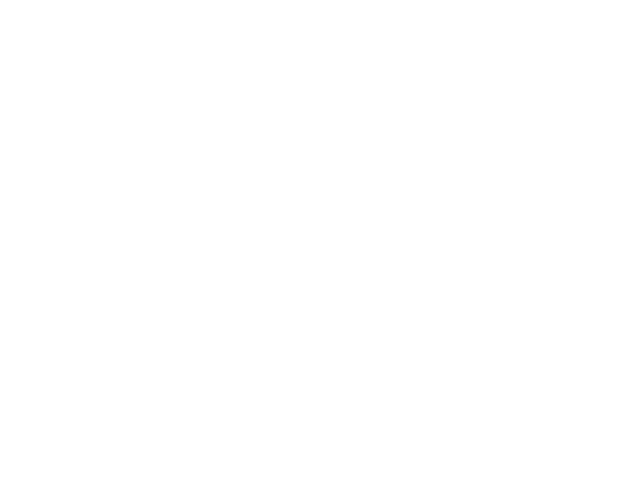

In [12]:
%matplotlib notebook
# Plot the surface.
#PLOT A SURFACE
fig = plt.figure('Llit')
ax = fig.gca(projection='3d')

fig.suptitle("Llit elàstic")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
ax.set_zlabel('Height (meters)')
ax.set_zlim(-1,0.1)

surf = ax.plot_surface(Pos[:,:,0], Pos[:,:,1], Pos[:,:,2], antialiased=True)
#plt.savefig("Llit estàtic Buit K20, 3D")

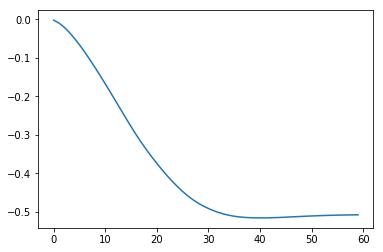

In [23]:
%matplotlib inline
plt.plot(altura_centre)
plt.savefig("Atenuacio=10, poca tensio inicial")

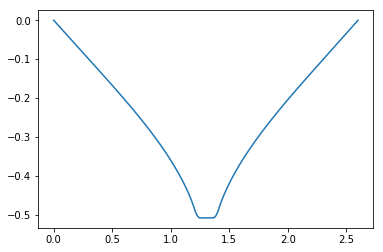

In [24]:
plt.plot(Pos[index_pos_centre[0],:,1], Pos[index_pos_centre[0],:,2])
#plotname = 'Tall eix Y, Anella, dens={densitat}, T0={tensio} K={ctelast}' \
#            .format(ctelast = str(K), densitat = str(densitat), tensio = str(Tensio_inicial))
#plt.savefig(plotname + '.png')

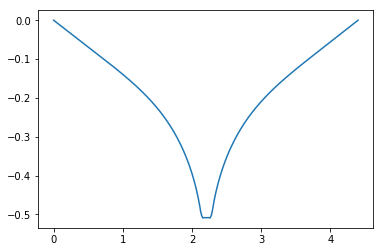

In [25]:
plt.plot(Pos[:,index_pos_centre[1],0], Pos[:,index_pos_centre[1],2])

#plotname = 'Tall eix X, Anella, dens={densitat}, T0={tensio} K={ctelast}' \
 #           .format(ctelast = str(K), densitat = str(densitat), tensio = str(Tensio_inicial))
#plt.savefig(plotname + '.png')

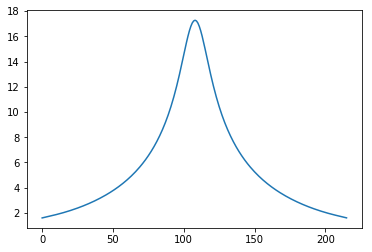

In [26]:
#Tensio_final_eixy = k_y * deformacio_actual_y
plt.plot(k_y*(np.linalg.norm(Pos[1:-1,2,:] - Pos[1:-1,1,:], axis = 1) - y_dist_repos))

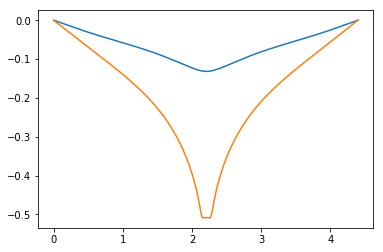

In [27]:
plt.plot(Pos[:,1,0], Pos[:,1,2])
plt.plot(Pos[:,index_pos_centre[1],0], Pos[:,index_pos_centre[1],2])

# Interpolant

# 1D

In [28]:
from autograd import grad
import autograd.numpy as np

In [29]:
x_to_inter, y_to_inter = Pos[:,index_pos_centre[1],0], Pos[:,index_pos_centre[1],2]

In [30]:
>>> from scipy.interpolate import interp1d
f = interp1d(x_to_inter, y_to_inter)
f2 = interp1d(x_to_inter, y_to_inter, kind='cubic')

In [33]:
np.min(x_to_inter), np.max(x_to_inter)

(0.0, 4.4000000000000004)

In [35]:
xnew = np.linspace(0, 4.4, num=1000, endpoint=True)
print(np.linalg.norm(f(xnew)-f2(xnew)))

0.00266857219407


In [37]:
fl = lambda x: float(f(x))

In [38]:
fl(2)

-0.3949710530615641

In [39]:
fl(2.2)

-0.5081245305550687

In [ ]:
g = grad(fl)

In [ ]:
g(0.2)

<IPython.core.display.Javascript object>


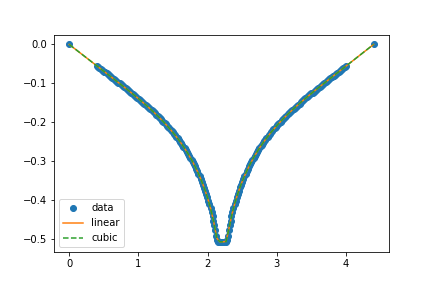

In [41]:
%matplotlib notebook

xnew = np.linspace(0, 4.4, num=100, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x_to_inter, y_to_inter, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

# 2D

In [61]:
>>> from scipy import interpolate
>>> x = np.arange(-5.01, 5.01, 0.25)
>>> y = np.arange(-5.01, 5.01, 0.25)
>>> xx, yy = np.meshgrid(x, y)
>>> z = np.sin(xx**2+yy**2)
>>> f = interpolate.interp2d(x, y, z, kind='cubic')

In [75]:
Pos[:,:,0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4       ,  0.4       ,  0.4       , ...,  0.4       ,
         0.4       ,  0.4       ],
       [ 0.41674419,  0.41674419,  0.41674419, ...,  0.41674419,
         0.41674419,  0.41674419],
       ..., 
       [ 3.98325581,  3.98325581,  3.98325581, ...,  3.98325581,
         3.98325581,  3.98325581],
       [ 4.        ,  4.        ,  4.        , ...,  4.        ,
         4.        ,  4.        ],
       [ 4.4       ,  4.4       ,  4.4       , ...,  4.4       ,
         4.4       ,  4.4       ]])

In [109]:
interpolate.interp2d?

In [78]:
>>> f = interpolate.interp2d(Pos[:,:,0], Pos[:,:,1], Pos[:,:,2], kind='cubic')

/media/pau/HDD/anaconda3/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=62,46 m=33572 fp=0.000001 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [83]:
f(Pos[:,:,0][20,20], Pos[:,:,1][20,20])

array([-0.06506123])

In [85]:
Pos[:,:,2][20,20]

-0.065061333133108801

In [82]:
Pos[:,:,0]aç

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4       ,  0.39960913,  0.39959065, ...,  0.39959657,
         0.39961488,  0.4       ],
       [ 0.41674419,  0.41635832,  0.41634052, ...,  0.4163473 ,
         0.41636489,  0.41674419],
       ..., 
       [ 3.98325581,  3.98366369,  3.98368226, ...,  3.98367585,
         3.98365747,  3.98325581],
       [ 4.        ,  4.00041166,  4.00043088, ...,  4.0004253 ,
         4.00040624,  4.        ],
       [ 4.4       ,  4.4       ,  4.4       , ...,  4.4       ,
         4.4       ,  4.4       ]])

In [102]:
>>> x = np.arange(-0, 4.4, 0.02)
>>> y = np.arange(0, 2.6, 0.02)
>>> xx, yy = np.meshgrid(x, y)

In [104]:
a, b = xx.shape
M = np.zeros((a,b))
for i in t(range(a)):
    for j in range(b):
        M[i,j] = f(xx[i,j], yy[i,j])

A Jupyter Widget

In [108]:
np.linalg.norm(M.reshape(-1))

23.69669627459951

<IPython.core.display.Javascript object>


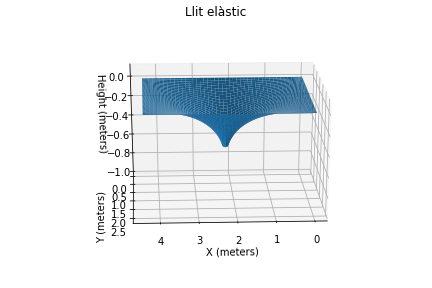

In [106]:
%matplotlib notebook
# Plot the surface.
#PLOT A SURFACE
fig = plt.figure('Llit')
ax = fig.gca(projection='3d')

fig.suptitle("Llit elàstic")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
ax.set_zlabel('Height (meters)')
ax.set_zlim(-1,0.1)
surf = ax.plot_surface(xx, yy, M, antialiased=True)
#surf = ax.plot_surface(Pos[:,:,0], Pos[:,:,1], Pos[:,:,2], antialiased=True)

<IPython.core.display.Javascript object>


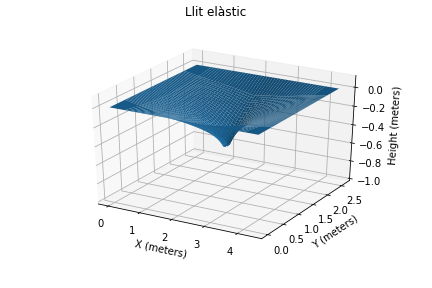

In [81]:
%matplotlib notebook
# Plot the surface.
#PLOT A SURFACE
fig = plt.figure('Llit')
ax = fig.gca(projection='3d')

fig.suptitle("Llit elàstic")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
ax.set_zlabel('Height (meters)')
ax.set_zlim(-1,0.1)

surf = ax.plot_surface(Pos[:,:,0], Pos[:,:,1], Pos[:,:,2], antialiased=True)
#plt.savefig("Llit estàtic Buit K20, 3D")

In [58]:
x.shape

(41,)

In [60]:
y.shape

(41,)

In [56]:
z.shape

(41, 41)

## Aquí sota es fa el recollit de dades a un .csv

In [ ]:
#Primer centrem a que el centre de la bola de bolos estigui en el (0,0)
Pos[:,:,0] = Pos[:,:,0] - x_mida_inici/2 - L_molla
Pos[:,:,1] = Pos[:,:,1] - y_mida_inici/2 - L_molla

"""
mostreig = 1 #Cada quants elements de l'eix en posem un en un csv.

Pos_x = Pos[::mostreig,index_pos_centre[1],0]
Pos_z = Pos[::mostreig,index_pos_centre[1],2]

Data = np.transpose([Pos_x, Pos_z])

np.savetxt('Tercera prova de llit',  Data,\
            delimiter=', ', header='EixX, EixZ')
"""

In [154]:
import pandas as pd
df = pd.read_csv("dadesllitreals.csv", header = None)
df = df[[0,1]]

In [155]:
df = df[abs(df[0]) > 10]

In [156]:
len(df)

76

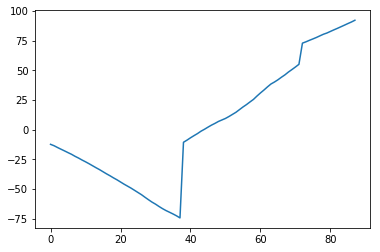

In [139]:
%matplotlib inline
plt.plot(df[0])

<IPython.core.display.Javascript object>


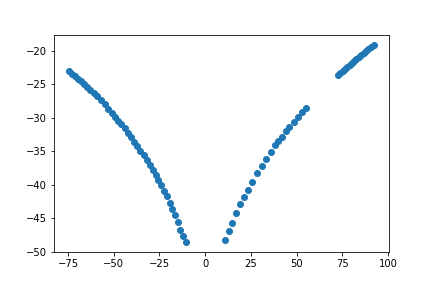

In [157]:
%matplotlib notebook
plt.scatter(df[0], df[1])

In [132]:
df

,0,1
0,-12.362139,-47.669812
1,-13.524426,-46.802620
2,-15.041715,-45.575383
3,-16.484563,-44.526093
4,-17.893305,-43.621532
5,-19.346534,-42.679899
6,-20.755276,-41.753095
7,-22.445766,-40.952337
8,-23.906410,-40.099677
9,-25.559828,-39.261846


In [131]:
df[0]

0    -12.362139
1    -13.524426
2    -15.041715
3    -16.484563
4    -17.893305
5    -19.346534
6    -20.755276
7    -22.445766
8    -23.906410
9    -25.559828
10   -27.072372
11   -28.673889
12   -30.364380
13   -32.054870
14   -33.656387
15   -35.435851
16   -37.200486
17   -38.831661
18   -40.611124
19   -42.242299
20   -44.058835
21   -45.875371
22   -47.543618
23   -49.211865
24   -51.065473
25   -52.919081
26   -54.772689
27   -56.922874
28   -58.998915
29   -61.000812
        ...    
58    25.451463
59    28.268947
60    30.901070
61    33.347833
62    35.979956
63    38.426719
64    40.094966
65    41.985646
66    44.135831
67    46.137728
68    48.510346
69    50.586387
70    52.736572
71    54.997974
72    72.829682
73    73.941847
74    75.202301
75    76.388610
76    77.611991
77    78.983661
78    80.318259
79    81.356279
80    82.690877
81    84.025474
82    85.285928
83    86.620526
84    87.955123
85    89.326793
86    90.624319
87    92.107205
Name: 0, Length: 88, dty

In [127]:
df[1]

0    -47.669812
1    -46.802620
2    -45.575383
3    -44.526093
4    -43.621532
5    -42.679899
6    -41.753095
7    -40.952337
8    -40.099677
9    -39.261846
10   -38.550061
11   -37.838275
12   -37.037517
13   -36.377632
14   -35.613946
15   -34.902160
16   -34.212618
17   -33.582391
18   -32.840948
19   -32.247794
20   -31.580495
21   -30.950268
22   -30.431258
23   -29.875175
24   -29.282021
25   -28.688866
26   -28.021567
27   -27.428413
28   -26.835258
29   -26.316248
        ...    
58   -39.662225
59   -38.327628
60   -37.252535
61   -36.177442
62   -35.065278
63   -34.101402
64   -33.471175
65   -32.840948
66   -32.025361
67   -31.358062
68   -30.579546
69   -29.875175
70   -29.207877
71   -28.503506
72   -23.647053
73   -23.350475
74   -22.979754
75   -22.683177
76   -22.423671
77   -22.090022
78   -21.793445
79   -21.496867
80   -21.274434
81   -20.903713
82   -20.681280
83   -20.384703
84   -20.088125
85   -19.754476
86   -19.494971
87   -19.087177
Name: 1, Length: 88, dty

In [128]:
plt

<module 'matplotlib.pyplot' from '/media/pau/HDD/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [129]:
plt.scatter(df[0], df[1])

AttributeError: 'NoneType' object has no attribute 'sqrt'

In [ ]:
df[1]

In [ ]:
x

In [ ]:
f(3.5)

In [ ]:
(f(3)+f(4))*0.5